In [120]:
import numpy as np
import pandas as pd
import datetime
from scipy import signal
import math

import matplotlib.pyplot as plt

# read, extract, resampled, sliced

In [87]:
def standardize_sensor_raw_info(path_csv_sensor, data_col_names):
    
    sensor_df = pd.read_csv(path_csv_sensor, names=data_col_names)
    unix_time = sensor_df.iloc[0,0]
    
    sampling_frequency = sensor_df.iloc[1,0]
    
    sensor_df_sliced = sensor_df.iloc[2 :, :]
    
    sensor_df_sliced_copy = sensor_df_sliced.copy()
    
    sensor_df_sliced_copy = sensor_df_sliced_copy.reset_index(drop=True)
    
    sampling_time = 1/sampling_frequency
    
    timestamps = unix_time + (sensor_df_sliced_copy.index)*sampling_time
    
    sensor_df_sliced_copy['timestamps'] = timestamps
    
    sensor_df_sliced_copy['starting_timestamp'] = ''
    
    sensor_df_sliced_copy['starting_timestamp'] = [unix_time]+['']*(len(sensor_df_sliced_copy)-1)
    
    end_time = timestamps[-1]
    sensor_df_sliced_copy['ending_timestamp'] = ''
    sensor_df_sliced_copy['ending_timestamp'] = [end_time]+['']*(len(sensor_df_sliced_copy)-1)
    
    
    sensor_df_sliced_copy['sampling_frequency'] = ''
    
    sensor_df_sliced_copy['sampling_frequency'] =[sampling_frequency]+['']*(len(sensor_df_sliced_copy)-1)
    
    return sensor_df_sliced_copy
    
    

In [88]:
def resample_sensor_data(original_standardize_df,  sensor_cols, new_sampling_frequency):
    
    
    orignal_sampling_frequecy = original_standardize_df["sampling_frequency"][0]
    
    multiplier = new_sampling_frequency/orignal_sampling_frequecy
    
    total_new_samples = multiplier * len(original_standardize_df)
    
    new_df = pd.DataFrame()
    
    
    for sensor_col in sensor_cols:
        
        #print(sensor_col)
        
        signal_array=original_standardize_df[sensor_col].values
        
        signal_array_resampled = signal.resample(signal_array, int(total_new_samples))
        
        
        new_df[sensor_col] = signal_array_resampled
        
        
    new_sampling_time = 1/new_sampling_frequency
    
    starting_time = original_standardize_df["starting_timestamp"][0]
    
    timestamps = starting_time + (new_df.index)*new_sampling_time
    
    
    
    new_df['timestamps'] = timestamps
    
    
    new_df['starting_timestamp'] = ''
    new_df['starting_timestamp'] = [starting_time]+['']*(len(new_df)-1)
    
    end_time = timestamps[-1]
    new_df['ending_timestamp'] = ''
    new_df['ending_timestamp'] = [end_time]+['']*(len(new_df)-1)
    
    new_df['sampling_frequency'] = ''
    new_df['sampling_frequency'] =[new_sampling_frequency]+['']*(len(new_df)-1)
    
    
    return new_df
        

In [89]:
def magnitude_acc_sensor(std_acc_df):    
    magnitude= np.sqrt(std_acc_df.iloc[:,0]**2 + std_acc_df.iloc[:,1]**2 + std_acc_df.iloc[:,2]**2)
    std_acc_df['magnitude'] = magnitude
    return std_acc_df

In [90]:
def normalize_signal (std_df, signal_col):
    
    signal = std_df[signal_col]
    
    mean_signal = np.mean(signal)
    
    mean_sub = signal - mean_signal
    
    scaled_data =  mean_sub/np.max(np.abs(mean_sub))
    
    std_df["mean_norm"] = scaled_data
    
    return std_df
    


In [91]:
def get_start_stop_timestamps(list_dfs):
    
    starting_time_list = [df["starting_timestamp"][0] for df in list_dfs]
    ending_time_list  = [df["ending_timestamp"][0] for df in list_dfs]
    
    late_start = max(starting_time_list)
    early_stop =min(ending_time_list)
    
    return late_start, early_stop

In [92]:
def align_slice_df(df, start_time, stop_time):
    
    sliced_df=df[(df.timestamps>=start_time)&(df.timestamps <= stop_time)]
    
    sliced_df =sliced_df.copy()
    
    return sliced_df

# Testing on the data 

### Accelorometer data

In [93]:
acc_sensor_path ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/datasets/Empatica/ACC.csv"
data_col_names = ['x', 'y', 'z']

In [94]:
acc_df_stand=standardize_sensor_raw_info (acc_sensor_path, data_col_names)
acc_df_stand = magnitude_acc_sensor(acc_df_stand)
acc_df_stand_norm = normalize_signal(acc_df_stand, 'magnitude')

## Heart rate data

In [95]:
hr_sensor_path ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/datasets/Empatica/HR.csv"
data_col_names = ['signal']

In [96]:
hr_df_stand=standardize_sensor_raw_info(hr_sensor_path, data_col_names)
hr_df_stand_resamp = resample_sensor_data(hr_df_stand,  ["signal"], 32)
hr_df_stand_resamp_norm = normalize_signal (hr_df_stand_resamp, "signal")

### Eda Data

In [97]:
eda_sensor_path ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/datasets/Empatica/EDA.csv"
data_col_names = ['signal']

In [98]:
eda_df_stand=standardize_sensor_raw_info(eda_sensor_path, data_col_names)
eda_df_resamp_stand = resample_sensor_data(eda_df_stand,  ["signal"], 32)
eda_df_stand_resamp_norm = normalize_signal (eda_df_resamp_stand, "signal")

## Alligning and slicing data of all the sensors 

In [99]:
list_dfs = [acc_df_stand_norm, hr_df_stand_resamp_norm, eda_df_stand_resamp_norm]

In [100]:
start_time, stop_time = get_start_stop_timestamps(list_dfs)    

In [101]:
acc_df_sliced_synced= align_slice_df(acc_df_stand_norm, start_time, stop_time)

In [102]:
eda_df_sliced_synced = align_slice_df(eda_df_stand_resamp_norm, start_time, stop_time)

In [103]:
hr_df_sliced_synced= align_slice_df(hr_df_stand_resamp_norm, start_time, stop_time)

In [104]:
hr_df_sliced_synced.shape 

(124096, 6)

In [105]:
eda_df_sliced_synced.shape

(124096, 6)

In [106]:
eda_df_sliced_synced

,signal,timestamps,starting_timestamp,ending_timestamp,sampling_frequency,mean_norm
320,0.055091,1.695387e+09,,,,-0.322092
321,0.042985,1.695387e+09,,,,-0.323655
322,0.032790,1.695387e+09,,,,-0.324971
323,0.026044,1.695387e+09,,,,-0.325841
324,0.023751,1.695387e+09,,,,-0.326138
...,...,...,...,...,...,...
124411,5.314990,1.695391e+09,,,,0.356929
124412,4.121475,1.695391e+09,,,,0.202854
124413,2.929519,1.695391e+09,,,,0.048979
124414,1.806666,1.695391e+09,,,,-0.095974


In [107]:
acc_df_sliced_synced.shape

(124096, 9)

In [108]:
acc_df_sliced_synced

,x,y,z,timestamps,starting_timestamp,ending_timestamp,sampling_frequency,magnitude,mean_norm
320,24.0,-7.0,57.0,1.695387e+09,,,,62.241465,-0.006782
321,24.0,-7.0,57.0,1.695387e+09,,,,62.241465,-0.006782
322,25.0,-7.0,57.0,1.695387e+09,,,,62.633857,-0.002078
323,24.0,-7.0,57.0,1.695387e+09,,,,62.241465,-0.006782
324,24.0,-7.0,57.0,1.695387e+09,,,,62.241465,-0.006782
...,...,...,...,...,...,...,...,...,...
124411,11.0,12.0,61.0,1.695391e+09,,,,63.134776,0.003927
124412,12.0,12.0,61.0,1.695391e+09,,,,63.316664,0.006107
124413,13.0,14.0,61.0,1.695391e+09,,,,63.921827,0.013362
124414,10.0,14.0,60.0,1.695391e+09,,,,62.417946,-0.004667


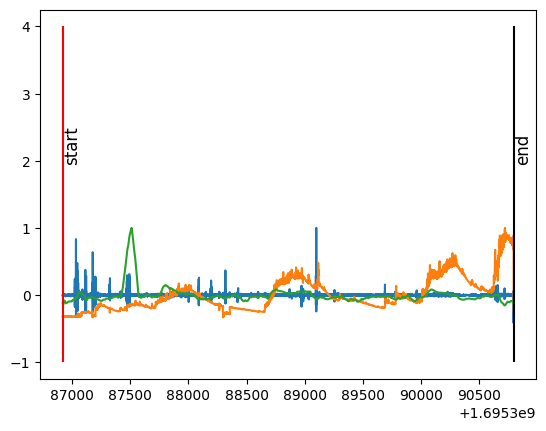

In [212]:
fsz = 26
fsz_fig= 32
fig, ax = plt.subplots()

##---------------------------------------------

ax.plot(acc_df_sliced_synced["timestamps"], acc_df_sliced_synced["mean_norm"])
ax.plot(eda_df_sliced_synced["timestamps"], eda_df_sliced_synced["mean_norm"])
ax.plot(hr_df_sliced_synced["timestamps"],hr_df_sliced_synced["mean_norm"])

ax.vlines(acc_df_sliced_synced["timestamps"].values[0], ymin=-1, ymax=4, color = 'red')
ax.text(x= acc_df_sliced_synced["timestamps"].values[0], y= 2, s="start", rotation = 90, fontsize = 12)

ax.vlines(acc_df_sliced_synced["timestamps"].values[-1], ymin=-1, ymax=4, color = 'black')
ax.text(x= acc_df_sliced_synced["timestamps"].values[-1], y= 2, s="end", rotation = 90, fontsize = 12)

plt.show()

## Behavioral Data

In [213]:
psychopy_csv_path = "/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/datasets/psychopy/237035_DigiRelax_Experiment_2023-10-17_16h09.10.215.csv"

In [214]:
psychopy_df = pd.read_csv(psychopy_csv_path)

In [112]:
psychopy_df

,Reference_time,baseline_instruction_ts,baseline_ts,sam_e_rt,sam_e_ts,mouse_e.x,mouse_e.y,mouse_e.leftButton,mouse_e.midButton,mouse_e.rightButton,...,relaxation_ts,saliva_probe_4_ts,final_instruction_ts,participant,session,date,expName,psychopyVersion,frameRate,Unnamed: 38
0,1.697552e+09,1.697552e+09,1.697552e+09,9.451555,1.697552e+09,0.191429,-0.148571,1.0,0.0,0.0,...,NaN,NaN,NaN,237035.0,1.0,2023-10-17_16h09.10.215,DigiRelax_Experiment,2022.2.4,121.543112,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,237035.0,1.0,2023-10-17_16h09.10.215,DigiRelax_Experiment,2022.2.4,121.543112,NaN
2,NaN,NaN,NaN,40.658728,1.697552e+09,0.192381,-0.155238,1.0,0.0,0.0,...,NaN,NaN,NaN,237035.0,1.0,2023-10-17_16h09.10.215,DigiRelax_Experiment,2022.2.4,121.543112,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,237035.0,1.0,2023-10-17_16h09.10.215,DigiRelax_Experiment,2022.2.4,121.543112,NaN
4,NaN,NaN,NaN,65.333847,1.697552e+09,0.192381,-0.155238,1.0,0.0,0.0,...,1.697552e+09,NaN,NaN,237035.0,1.0,2023-10-17_16h09.10.215,DigiRelax_Experiment,2022.2.4,121.543112,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,237035.0,1.0,2023-10-17_16h09.10.215,DigiRelax_Experiment,2022.2.4,121.543112,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.697552e+09,1.697552e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
psychopy_ref = float(psychopy_df["Reference_time"][0])

In [118]:
psychopy_ref

1697551753.963336

In [130]:
baseline_instruct_time = float([val for val in psychopy_df["baseline_instruction_ts"].tolist() if not(math.isnan(val))][0])

In [131]:
baseline_instruct_time

1697551759.512417

In [132]:
sam_e_ts = [val for val in psychopy_df["sam_e_ts"].tolist() if not(math.isnan(val))]

In [133]:
sam_e_ts

[1697551764.430419, 1697551795.637574, 1697551820.3126771]

In [137]:
relaxtion_ts = float([val for val in psychopy_df["relaxation_ts"].tolist() if not(math.isnan(val))][0])

In [138]:
saliva_4_ts = float([val for val in psychopy_df["saliva_probe_4_ts"].tolist() if not(math.isnan(val))][0])

In [139]:
saliva_4_ts

1697551826.718216

In [140]:
final_instruction = float([val for val in psychopy_df["final_instruction_ts"].tolist() if not(math.isnan(val))][0])

In [141]:
final_instruction

1697551833.801795

In [142]:
ts_array =np.arange(psychopy_ref, final_instruction, 1)

In [151]:
list_ts_array = list(ts_array)

(1697551753.963336, 1697551832.963336)

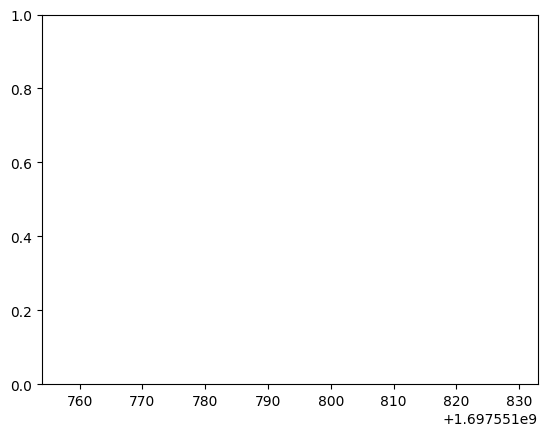

In [157]:
plt.xlim(list_ts_array[0], list_ts_array[-1])

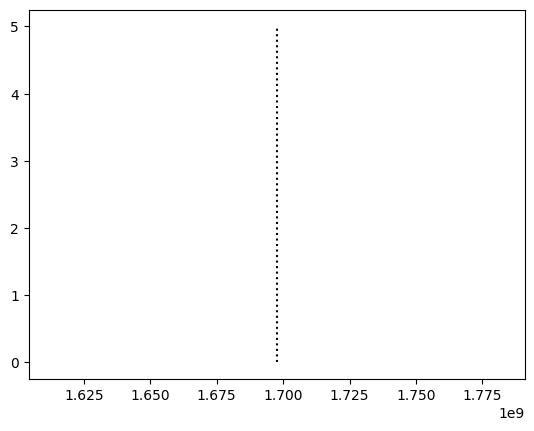

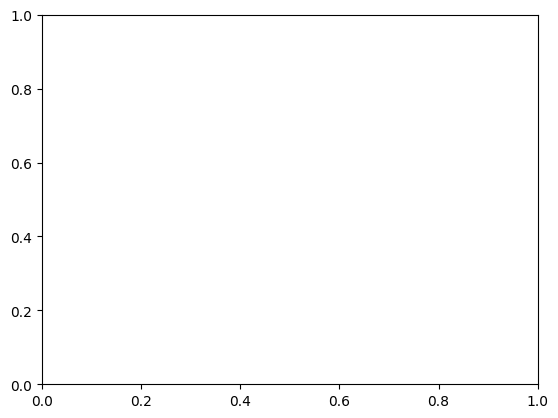

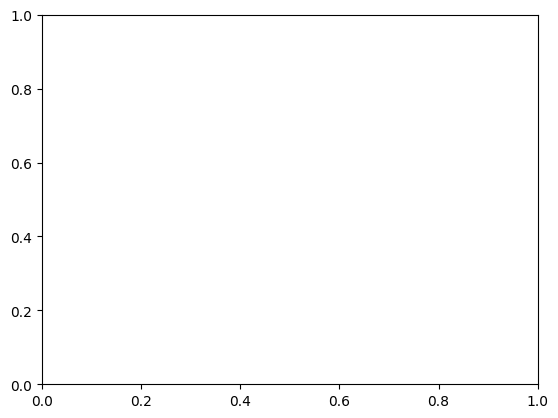

In [179]:
fig, ax = plt.subplots(1,1)

In [184]:
ax.vlines(psychopy_ref, 0, 5, linestyles ="dashed", colors ="k")
ax.text(x = psychopy_ref, y = 2, s = 'REF', rotation=90, fontsize = 26)
#plt.show()
#plt.text(x = event_df['reference_time(psy)'][0] - offset, y = 2, s = 'REF', rotation=90, fontsize = fsz)
#plt.vlines(baseline_instruct_time, 0, 5, linestyles ="dotted", colors ="k")
#plt.vlines(saliva_4_ts, 0, 5, linestyles ="solid", colors ="k")
#plt.show()

Text(1697551753.963336, 2, 'REF')

In [190]:
ax.vlines(psychopy_ref, 0, 5, linestyles ="dashed", colors ="k")
ax.text(x = psychopy_ref, y = 2, s = 'REF', rotation=90, fontsize = 26)
#ax.vlines(baseline_instruct_time, 0, 5, linestyles ="dotted", colors ="k")

Text(1697551753.963336, 2, 'REF')

(1697551753.963336, 1697551832.963336)

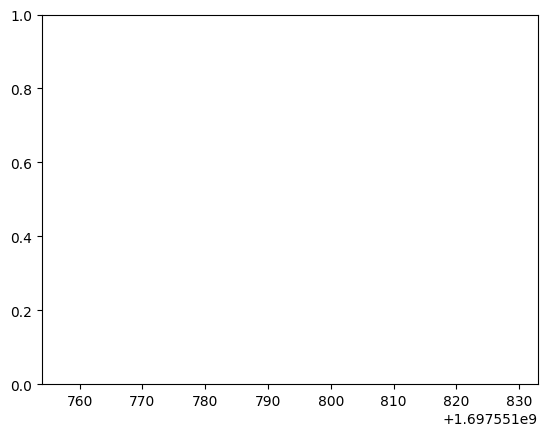

In [192]:
plt.xlim(list_ts_array[0], list_ts_array[-1])

In [193]:
plt.show()